# Importing external modules

In [21]:
import pandas as pd # For data manipulation
import pandas as pd # For data manipulation
import numpy as np # To perform different operations
import sqlite3
import random
import matplotlib.pyplot as plt # For plotting and data visualization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split #For splitting training data
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import json

# Loading and pre processing data. 

### Read csv files and create dataframes for each dataset

In [22]:
train_df = pd.read_csv('input/train.csv',sep=',')
test_df = pd.read_csv('input/test.csv',sep=',')

### Connect to database and import data from dataframes to the database

In [26]:
def DB_Connection(db_name):
    ''' Returns a Database connection'''
    conn = sqlite3.connect(db_name)
    print("Connection to DB successfully")
    return conn

db_conn = DB_Connection('fruitrient_db')
cursor = db_conn.cursor()

train_df.to_sql(name='train_images', con=db_conn, if_exists='append')
test_df.to_sql(name='test_images', con=db_conn, if_exists='append')

Connection to DB successfully


### List all tables in database

In [37]:
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('train_images',)
('test_images',)


### Load train and test data from database

In [45]:
train_data = pd.read_sql_query("SELECT * FROM train_images",db_conn)
train_data = train_data.drop('index', axis =1)

In [50]:
test_data = pd.read_sql_query("SELECT * FROM test_images",db_conn)
test_data = test_data.drop('index', axis =1)

### Print the traind and test data shapes

In [52]:
print("Fruits training dataset is of shape: ", train_data.shape,
     "\n\nFruits testing dataset is of shape: ", test_data.shape)

Fruits training dataset is of shape:  (11787, 785) 

Fruits testing dataset is of shape:  (5067, 785)


### Split data into pixels (X) and labels (y)

In [53]:
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:, 0]

X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:, 0]

# Visualizing and exploring data

### Visualizing 25 random fruits with their defined labels

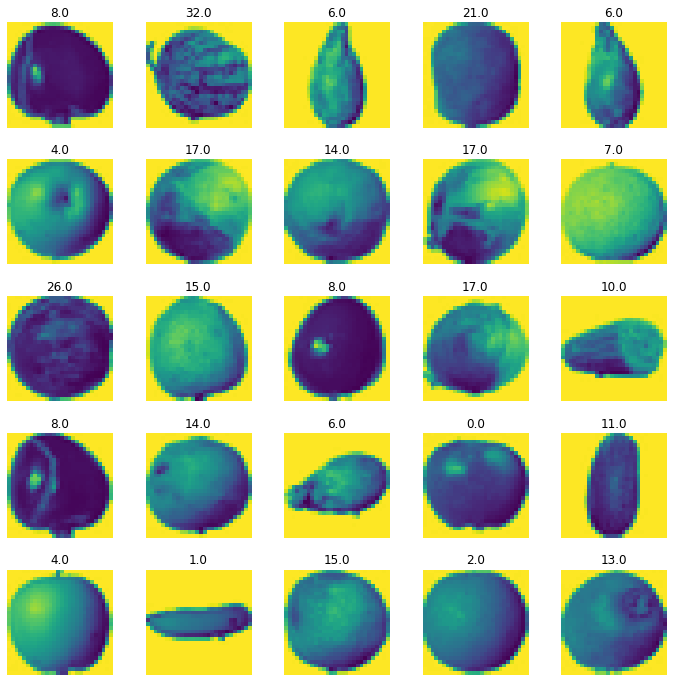

In [54]:
# Store data in numpy arrays for manual testing
fruits_arr = np.array(train_data, dtype = 'float32')

W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, W_grid * L_grid):

    random_number = np.random.randint(0, len(fruits_arr))  
    axes[i].imshow( fruits_arr[random_number,1:].reshape((28,28)) )
    axes[i].set_title(fruits_arr[random_number,0], fontsize = 12)
    axes[i].axis('off') 

plt.subplots_adjust(hspace=0.3)

### Graph showing the distribution of photos in the training and testing datasets

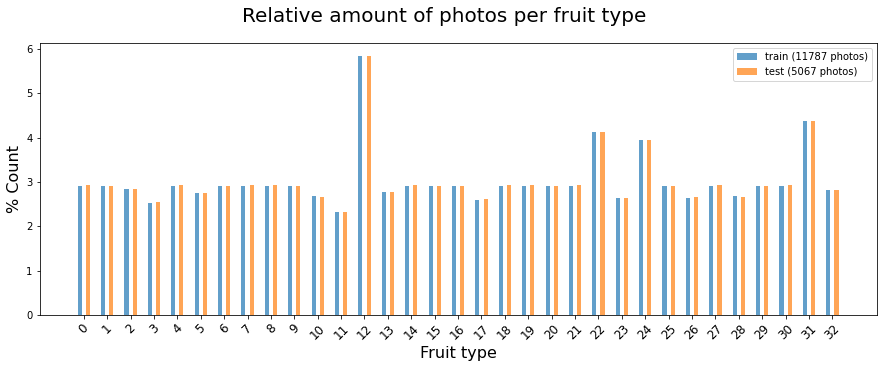

In [7]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% Count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'Count'
         
    xtemp = np.arange(len(unique))
       
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width/2)
    plt.xticks(xtemp, unique, rotation=45, fontsize=12)
    plt.xlabel('Fruit type',fontsize=16)
    plt.ylabel(ylabel_text, fontsize=16)
 

plt.figure(figsize=(15, 5))
plt.suptitle('Relative amount of photos per fruit type', fontsize=20)
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);


# Training and evaluating the model

### Split the training set into 80% training and 20% validation

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

### Train the model using Randm forest classifier

In [9]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

### Evaluate the model on validation set

In [10]:
rf.score(X_val, y_val)

0.9987277353689568

# Making predictions and measuring performance

### Make predicitons on the test dataset

In [11]:
prediction = rf.predict(X_test) 

### Display images from the test dataset along with their predicted and true class

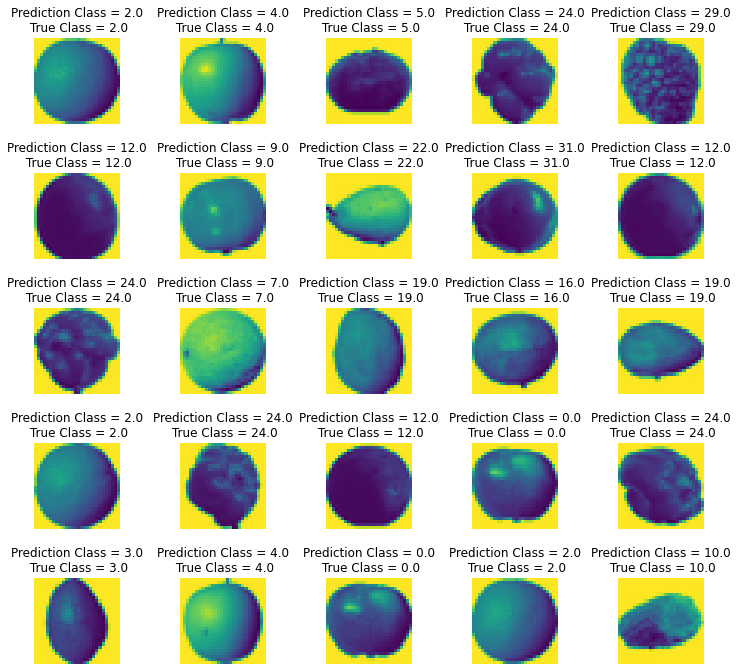

In [13]:
# Create arrays from test dataframes for manual tesing purposes
X_test_arr = np.array(X_test, dtype = 'float32')
y_test_arr = np.array(y_test, dtype = 'float32')

#Visualization of images along with their true and prectied class
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel() # 

for i in np.arange(0, L * W): 
    
    random_number = np.random.randint(0, len(y_test_arr))  
    axes[i].imshow(X_test_arr[random_number].reshape(28,28))
    axes[i].set_title("Prediction Class = {:0.1f}\n True Class = {:0.1f}".format(prediction[random_number], y_test_arr[random_number]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.7)

### Accuracy

In [14]:
print(
    f"Classification report for {rf}:\n\n"
    f"{metrics.classification_report(y_test, prediction)}\n"
)

Classification report for RandomForestClassifier():

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00       144
           3       1.00      1.00      1.00       129
           4       1.00      1.00      1.00       148
           5       1.00      1.00      1.00       139
           6       1.00      1.00      1.00       147
           7       1.00      1.00      1.00       148
           8       1.00      1.00      1.00       148
           9       1.00      1.00      1.00       147
          10       1.00      1.00      1.00       135
          11       1.00      1.00      1.00       118
          12       1.00      1.00      1.00       296
          13       1.00      1.00      1.00       140
          14       1.00      1.00      1.00       148
          15       1.00      1.00      1.00       147
          16       1.00     

### Confusing Matrix 
see what i did there

In [15]:
cm = confusion_matrix(y_test, prediction)

In [16]:
# A funcition provided by ScikitLearn to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.title('Confusion Matrix', fontsize=16)

In [17]:
#Get the corresponding names for each fruit label to display them in the matrix
with open('./input/fruits-labels.json') as read_file:
    fruits_labels = json.load(read_file)

labels = []
typ = fruits_labels.get('type')
for i in typ:
    labels.append(i)

Confusion matrix, without normalization
[[148   0   0 ...   0   0   0]
 [  0 147   0 ...   0   0   0]
 [  0   0 144 ...   0   0   0]
 ...
 [  0   0   0 ... 147   0   0]
 [  0   0   0 ...   0 222   0]
 [  0   0   0 ...   0   0 143]]


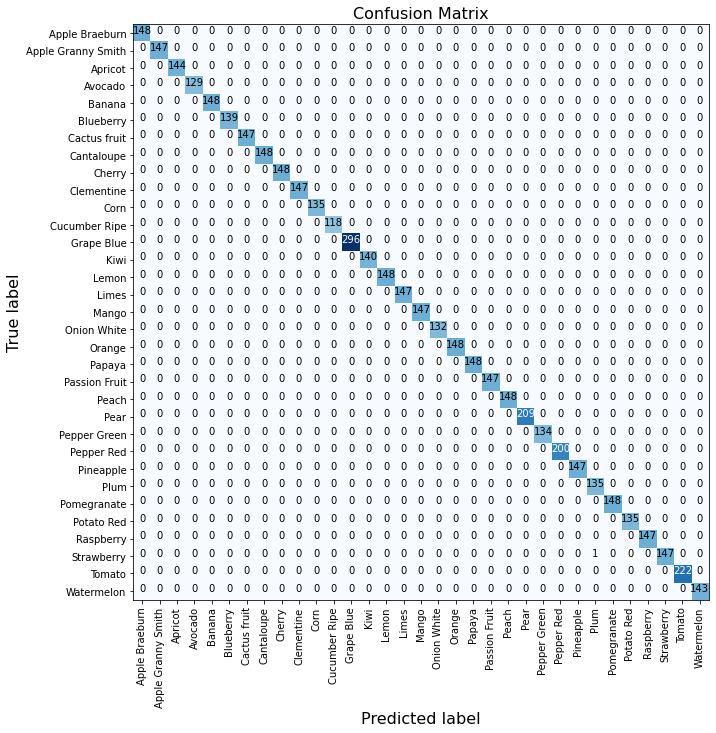

In [18]:
#Plot the confusion matrix
plt.figure(figsize=(10, 10))

plot_confusion_matrix(cm=cm, classes=labels)